# Asthma Prediction Model

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay

from xgboost import XGBClassifier


from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import pickle
import joblib

In [6]:
PATH = r"data\asthma_disease_data.csv"
df = pd.read_csv(PATH, sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               2392 non-null   int64  
 1   Age                     2392 non-null   int64  
 2   Gender                  2392 non-null   int64  
 3   Ethnicity               2392 non-null   int64  
 4   EducationLevel          2392 non-null   int64  
 5   BMI                     2392 non-null   float64
 6   Smoking                 2392 non-null   int64  
 7   PhysicalActivity        2392 non-null   float64
 8   DietQuality             2392 non-null   float64
 9   SleepQuality            2392 non-null   float64
 10  PollutionExposure       2392 non-null   float64
 11  PollenExposure          2392 non-null   float64
 12  DustExposure            2392 non-null   float64
 13  PetAllergy              2392 non-null   int64  
 14  FamilyHistoryAsthma     2392 non-null   

In [7]:
# protected variables: (age, gender, ethnicity, education level, family history)
Y = df['Diagnosis']
X = df.drop([ 'Diagnosis','PatientID', 'DoctorInCharge'], axis=1)
X_Y = df.drop([  'PatientID', 'DoctorInCharge'], axis=1)

In [56]:
corr = X_Y.corr()

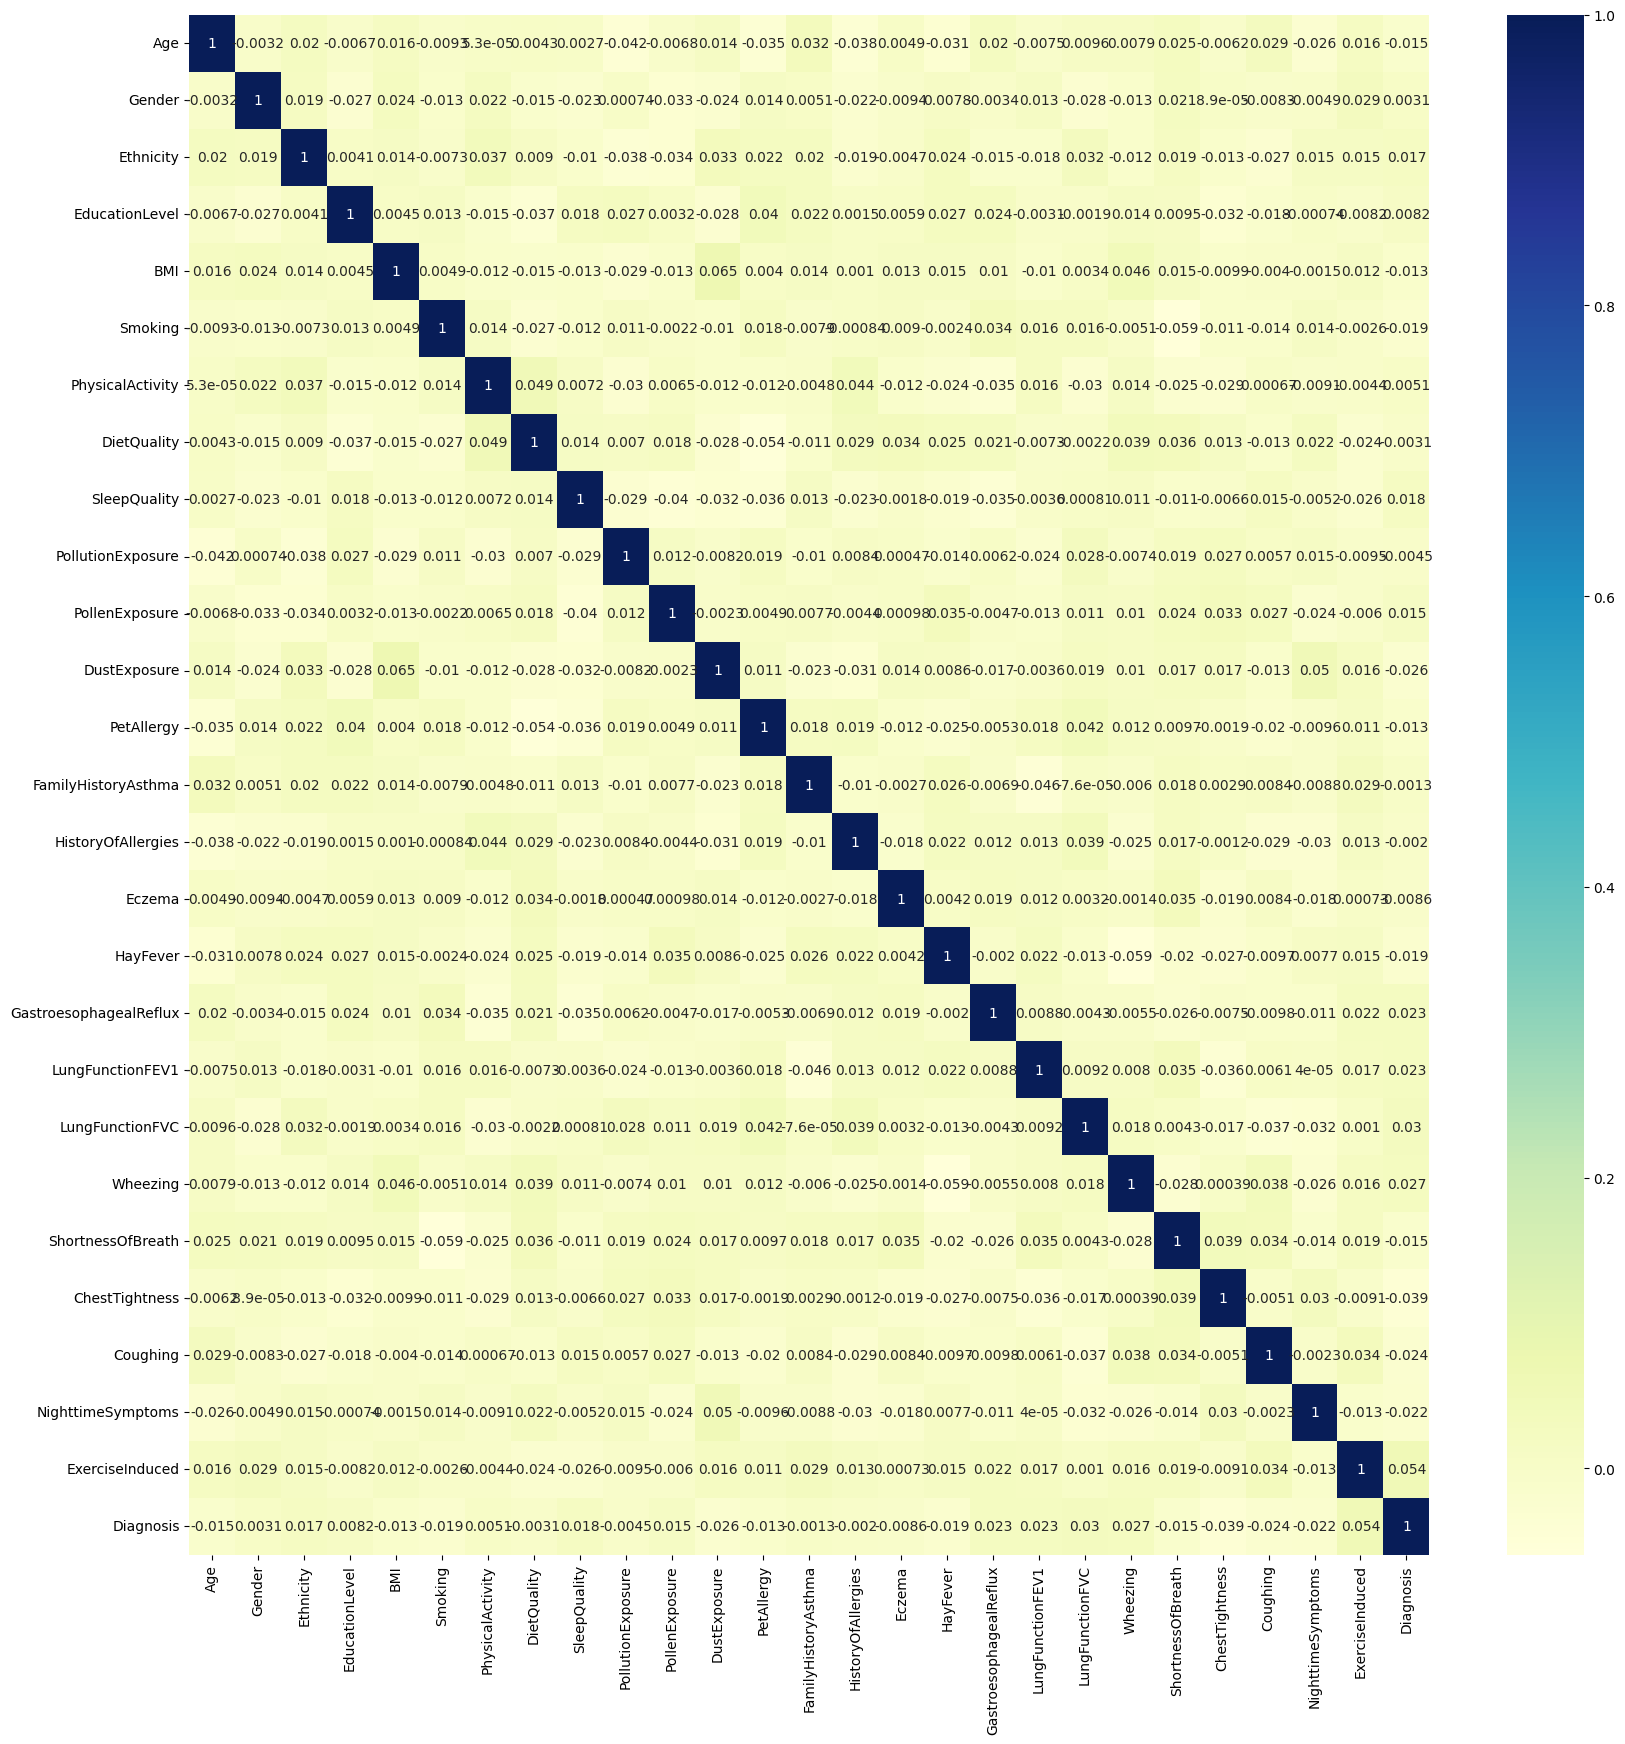

In [46]:

fig = plt.figure(figsize=(20, 20))
sns.heatmap(corr, cmap="YlGnBu", annot=True) 
plt.show() 

The Coorelation Matrix shows that the data is barely linearly correlated. The target variable 'diagnosis' also does not seem to be (linearly) predictable.

In [8]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state= 31) 
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state =31)

In [9]:
print(f" Training data: {len(X_train):10d} of which {len(X_train[Y_train==1])} ({len(X_train[Y_train==1])/len(X_train):.3f}%)have Asthma")
print(f" Validation data: {len(X_val):8d} of which {len(X_val[Y_val==1])} ({len(X_val[Y_val==1]) / len(X_val):.3f}%) have Asthma")
print(f" Test data: {len(X_test):14d} of which {len(X_test[Y_test==1])} ({len(X_test[Y_test==1]) / len(X_test):.3f}%)have Asthma")

 Training data:       1434 of which 70 (0.049%)have Asthma
 Validation data:      479 of which 26 (0.054%) have Asthma
 Test data:            479 of which 28 (0.058%)have Asthma


In [10]:
over = RandomOverSampler(random_state=42)
X_train_over, Y_train_over = over.fit_resample(X_train, Y_train)
scaler = StandardScaler()
scaler.fit(X_train_over)
X_train_scaled = scaler.transform(X_train_over)
X_val_scaled = scaler.transform(X_val)

In [11]:
# selection of some classifiers for binary classification problem

names = [ "Random Forest 200 ","Random Forest", "K Neighbors", 
         "Logistic Regression", "Decision Tree"]
models = [RandomForestClassifier(n_estimators=200), RandomForestClassifier(),
          KNeighborsClassifier(), LogisticRegression(max_iter = 1000), DecisionTreeClassifier() ]
results= dict()

In [12]:
# fit the models on training data

for model in models:
    model.fit(X_train_scaled, Y_train_over)

In [13]:
# predict probability of target classes for test data for each classifier

for name, model in zip(names, models):
    y_predict = model.predict_proba(X_val_scaled)
    results[name] = y_predict

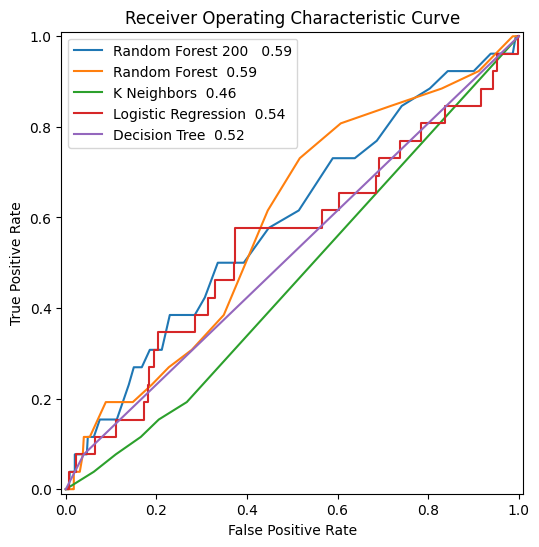

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))

for name in names:
    Y_pred = [prob[1] for prob in results[name]]
    auc = roc_auc_score(Y_val, Y_pred)
    RocCurveDisplay.from_predictions(
        Y_val,
        Y_pred,
        name=f"ROC curve for {name}",
        ax=ax,
        label = f"{name} {auc: .2f}"
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Receiver Operating Characteristic Curve",
)
plt.legend()

In [24]:
for name, model in zip(names, models):
    Y_pred = model.predict(X_val)
    print(f"Report for {name}")
    print(classification_report(Y_val, Y_pred))

Report for Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       453
           1       1.00      1.00      1.00        26

    accuracy                           1.00       479
   macro avg       1.00      1.00      1.00       479
weighted avg       1.00      1.00      1.00       479

Report for K Neighbors
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       453
           1       0.00      0.00      0.00        26

    accuracy                           0.95       479
   macro avg       0.47      0.50      0.49       479
weighted avg       0.89      0.95      0.92       479

Report for Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       453
           1       0.90      1.00      0.95        26

    accuracy                           0.99       479
   macro avg       0.95      1.00      0.97      

c:\Users\thiel\AppData\Local\pypoetry\Cache\virtualenvs\group-project-zckzj0tR-py3.11\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\thiel\AppData\Local\pypoetry\Cache\virtualenvs\group-project-zckzj0tR-py3.11\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\thiel\AppData\Local\pypoetry\Cache\virtualenvs\group-project-zckzj0tR-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thiel\AppData\Local\pypoetry\Cache\virtualenvs\group-project-zckzj0tR-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: Unde

All "simpler models" fail predicting Asthma based on the given input data.
Ideas to overcome this problem:
- use scaler and normilize input features -> so that they are all on the same range
- use feature selection, create nonlinear features
- use more complex models GradienBoost or XGBoost
- optimize hyperparameters
- cross validation to prevent overfitting

In [15]:
def plot_roc(Y_pred, Y_test, name):
    fig, ax = plt.subplots(figsize=(6, 6))

    
    RocCurveDisplay.from_predictions(
        Y_test,
        Y_pred,
        name=f"ROC curve for {name} classifier",
        ax=ax,
    )

    _ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Receiver Operating Characteristic Curve",
    )
    plt.legend()


This also didn't work. Next try is to train several SVM models with differetn kernels, e.g. 'linear', 'poly', 'rbf', sigmoid'.

In [16]:
def create_svm_model(kernel: str):
    clf = svm.SVC(kernel=kernel, gamma=2, probability=True, class_weight='balanced').fit(X_train_scaled, Y_train_over)
    Y_pred_clf = clf.predict(X_val_scaled)
    Y_pred_prob = clf.predict_proba(X_val_scaled)
    Y_prob = [prob[1] for prob in Y_pred_prob]
    print(classification_report(Y_val, Y_pred_clf))
    plot_roc(Y_prob, Y_val, f'SVM with {kernel} kernel')
    filename = f"SVM_{kernel}_scaled.sav"
    # pickle.dump(clf, open(filename, 'wb'))
    

              precision    recall  f1-score   support

           0       0.96      0.58      0.72       453
           1       0.07      0.58      0.13        26

    accuracy                           0.58       479
   macro avg       0.52      0.58      0.42       479
weighted avg       0.91      0.58      0.69       479



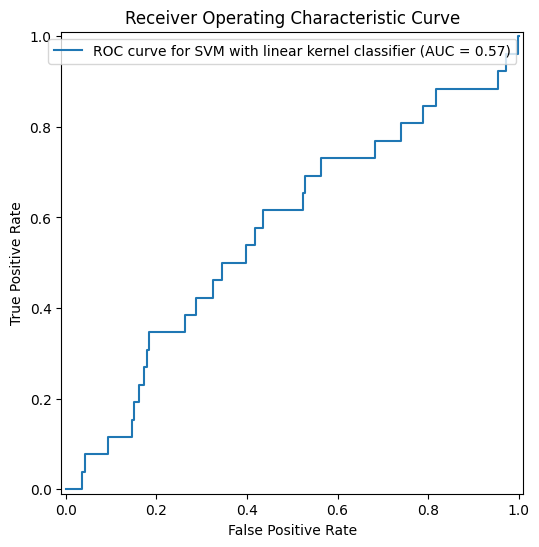

In [17]:
create_svm_model('linear')

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       453
           1       0.00      0.00      0.00        26

    accuracy                           0.94       479
   macro avg       0.47      0.49      0.48       479
weighted avg       0.89      0.94      0.91       479



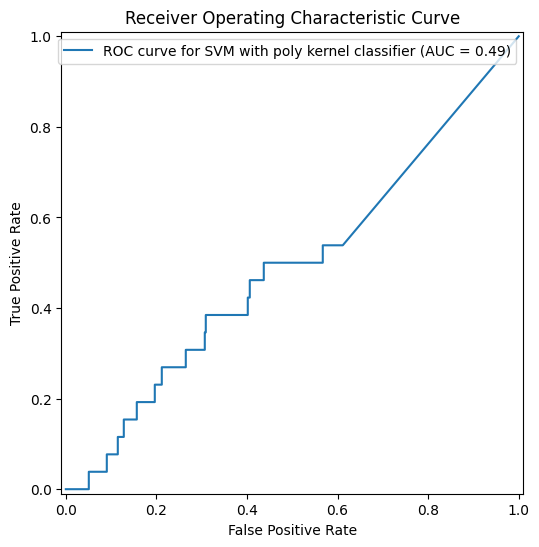

In [18]:
create_svm_model('poly')

c:\Users\thiel\AppData\Local\pypoetry\Cache\virtualenvs\group-project-zckzj0tR-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thiel\AppData\Local\pypoetry\Cache\virtualenvs\group-project-zckzj0tR-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thiel\AppData\Local\pypoetry\Cache\virtualenvs\group-project-zckzj0tR-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       453
           1       0.00      0.00      0.00        26

    accuracy                           0.95       479
   macro avg       0.47      0.50      0.49       479
weighted avg       0.89      0.95      0.92       479



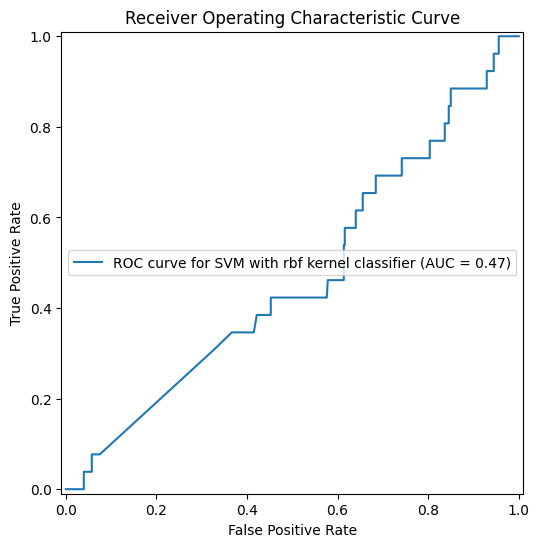

In [40]:
create_svm_model('rbf')

              precision    recall  f1-score   support

           0       0.96      0.45      0.61       453
           1       0.07      0.69      0.12        26

    accuracy                           0.46       479
   macro avg       0.51      0.57      0.37       479
weighted avg       0.91      0.46      0.58       479



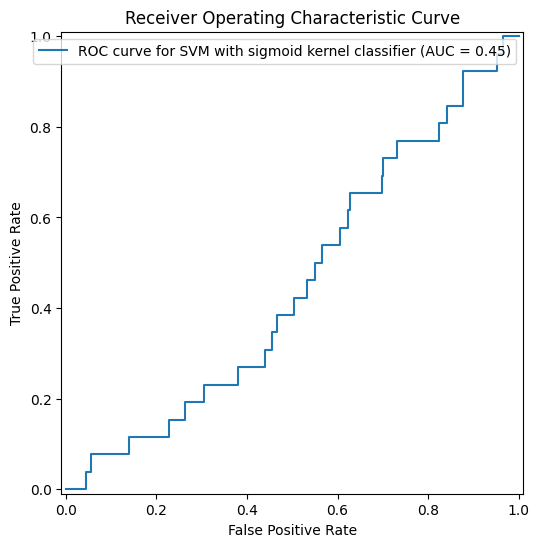

In [41]:
create_svm_model('sigmoid')

### Final Model Training and Testing

The best performing model on validation data was the Random Forest Classifier. We will now train the model on train and validationd data and report perfromance on the test data.

In [23]:
# train on merged train/val data set
X_t_v_over, Y_t_v_over = over.fit_resample(X_train_val, Y_train_val)
scaler2 = StandardScaler()
scaler2.fit(X_t_v_over)
joblib.dump(scaler2, 'scaler.pkl')
X_t_v_scaled = scaler2.transform(X_t_v_over)
X_test_scaled = scaler2.transform(X_test)

c:\Users\thiel\AppData\Local\pypoetry\Cache\virtualenvs\group-project-zckzj0tR-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thiel\AppData\Local\pypoetry\Cache\virtualenvs\group-project-zckzj0tR-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thiel\AppData\Local\pypoetry\Cache\virtualenvs\group-project-zckzj0tR-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       451
           1       0.00      0.00      0.00        28

    accuracy                           0.94       479
   macro avg       0.47      0.50      0.48       479
weighted avg       0.89      0.94      0.91       479



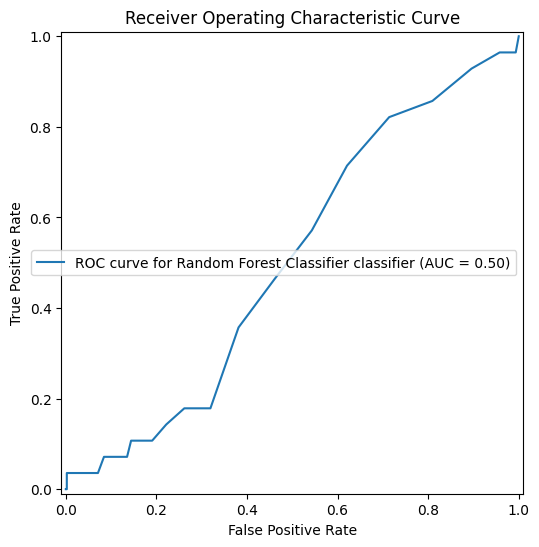

In [20]:
MODEL = RandomForestClassifier(class_weight='balanced').fit(X_t_v_scaled, Y_t_v_over)
Y_pred_clf = MODEL.predict(X_test_scaled)
Y_pred_prob = MODEL.predict_proba(X_test_scaled)
Y_prob = [prob[1] for prob in Y_pred_prob]
print(classification_report(Y_test, Y_pred_clf))
plot_roc(Y_prob, Y_test, f'Random Forest Classifier')
filename = "RandomForest_p.sav"
pickle.dump(MODEL, open(filename, 'wb'))

              precision    recall  f1-score   support

           0       0.94      0.55      0.70       451
           1       0.06      0.43      0.10        28

    accuracy                           0.54       479
   macro avg       0.50      0.49      0.40       479
weighted avg       0.89      0.54      0.66       479



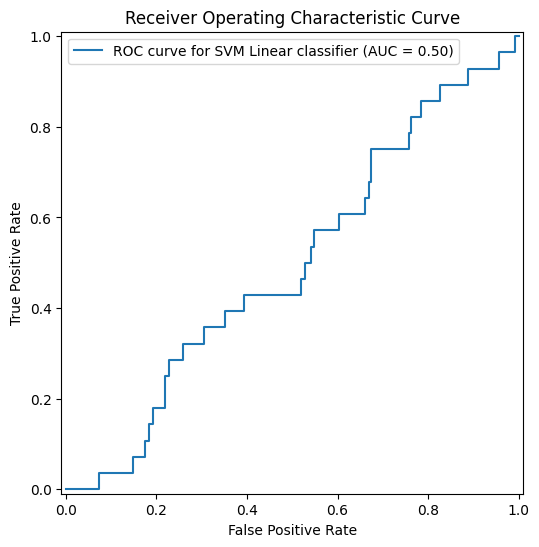

In [21]:
MODEL = svm.SVC(kernel='linear', gamma=2, probability=True, class_weight='balanced').fit(X_t_v_scaled, Y_t_v_over)
Y_pred_clf = MODEL.predict(X_test_scaled)
Y_pred_prob = MODEL.predict_proba(X_test_scaled)
Y_prob = [prob[1] for prob in Y_pred_prob]
print(classification_report(Y_test, Y_pred_clf))
plot_roc(Y_prob, Y_test, f'SVM Linear')
filename = "app/SVM_linear_scaled_p.sav"
pickle.dump(MODEL, open(filename, 'wb'))